<a href="https://colab.research.google.com/github/vvvin333/PassportDateOCR/blob/main/PassportDateOCRTesseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Detect and recognize date from passport and determine age***

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,783 kB/s)
debconf: unable to initi

In [ ]:
!pip install pytesseract
!pip install dateparser
!pip install scikit-image

_____________________________

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import random
from skimage.filters import threshold_local


def rescale_image(img):
  # rescales the very large images
  height, width = img.size
  factor = min(1, float(1024.0 / height))
  size = int(factor * height), int(factor * width)
  img = img.resize(size, Image.ANTIALIAS)
  img = np.array(img)
  # adding border to image
  img = cv2.copyMakeBorder(img,10,10,10,10,cv2.BORDER_CONSTANT,value=[0,0,0])
  return img

def auto_canny(img, sigma=0.50):
  # compute the median of pixel intensities
	med = np.median(img)
	# apply Canny edge detection using computed median
	lower = int(max(0, (1.0 - sigma) * med))
	upper = int(min(255, (1.0 + sigma) * med))
	edge_img = cv2.Canny(img, lower, upper)
	# return the edged image
	return edge_img

def edged(img):
  # find edges in image
  # convert rgb to gray
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # blur to remove noise
  blur = cv2.GaussianBlur(gray, (5, 5), 0)
  # find edges
  edge_img = auto_canny(blur)
  return edge_img

def threshold(img):
  # threshold an image
  # convert rgb to gray
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # invert image
  gray = cv2.bitwise_not(gray)
  # blur to remove noise
  blur = cv2.GaussianBlur(gray, (5, 5), 0)
  # apply thresholding
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  edge_img = edged(img)
  thresh = cv2.bitwise_or(edge_img, thresh)
  return thresh

def find_bbox(thresh):
  # finds bounding box of receipt
  # finding contours
  cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
  # sorting contours by area
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
  # finding min area rect for second biggest contour
  rect = cv2.minAreaRect(cnts[1])
  bbox = cv2.boxPoints(rect)
  bbox = np.int0(bbox)
  return cnts, bbox

def crop_img(img, bbox):
  # crop the image using receipt bounding box
  left, top = bbox[bbox.sum(axis=1).argmin()]
  right, bottom = bbox[bbox.sum(axis=1).argmax()]
  img = img[top:bottom,left:right]
  return img

def image_smoothening(img):
  # thresholding with less noise 
  ret1, th1 = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
  blur = cv2.GaussianBlur(th1, (5, 5), 0)
  ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return th2

def remove_noise_and_smooth(img):
  # thresholding image for final OCR
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  thresh = threshold_local(gray, 11, offset = 10, method = "gaussian")
  thresh = (gray > thresh).astype("uint8") * 255
  # applying morph operations
  kernel = np.ones((1, 1), np.uint8)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
  smooth_img = image_smoothening(gray)
  # merging both threshold
  final_img = cv2.bitwise_or(smooth_img, thresh)
  return final_img

def random_string():
  return ''.join([chr(random.randint(97,122)) for i in range(10)])


In [ ]:
import pytesseract
import re


def find_date(text, regex=r"(19|20)\d{2}"):
    '''
    default regex: for year 1900-2099
    regex samples for date:
    regex = r"((19|20)?\d{1,2}\s?[-/]\s?\d{1,2}\s?[-/]\s?(19|20)?\d{2})|"\
            r"((Jan|Feb|Mar|Apr|May|Jun|June|Jul|Aug|Sept|Sep|Oct|Nov|Dec)"\
            r"\s?\d{1,2}\s?[,']?\s?(19|20)?\d{2})|(\d{1,2}\s?[-/]?\s?"\
            r"(Jan|Feb|Mar|Apr|May|Jun|June|Jul|Aug|Sept|Sep|Oct|Nov|Dec)"\
            r"\s?[',-/]?\s?(19|20)?\d{1,2})"
    regex = r"^(?:(?:31(\/|-|\.)(?:0?[13578]|1[02]))\1|(?:(?:29|30)(\/|-|\.)"\
            r"(?:0?[13-9]|1[0-2])\2))(?:(?:1[6-9]|[2-9]\d)?\d{2})$|"\
            r"^(?:29(\/|-|\.)0?2\3(?:(?:(?:1[6-9]|[2-9]\d)?(?:0[48]|[2468][048]"\
            r"|[13579][26])|(?:(?:16|[2468][048]|[3579][26])00))))$|^(?:0?[1-9]"\
            r"|1\d|2[0-8])(\/|-|\.)(?:(?:0?[1-9])|(?:1[0-2]))\4(?:(?:1[6-9]"\
            r"|[2-9]\d)?\d{2})"
    regex = r"(19|20)\d{2}"
    '''
    pattern = re.compile(regex, flags=re.IGNORECASE)
    matches = list(re.finditer(pattern, text))
    if len(matches)==0:
        return None
    result = [int(match.group()) for match in matches]
    return result

def find_date_from_image(img):
    # preprocessing image
    img = rescale_image(img)
    thresh = threshold(img)
    cnts, bbox = find_bbox(thresh)
    img = crop_img(img, bbox)
    final_img = remove_noise_and_smooth(img)
    
    # finding text in image
    text = pytesseract.image_to_string(final_img)
    
    # searching for dates
    date = find_date(text)
    return date

In [ ]:
import cv2
import datetime
from PIL import Image


def age_recognition(img_name):
    path = img_name #f'./images/{img_name}'  
    try:
        img = Image.open(path)
    except:
        return ValueError
    years_from_image = find_date_from_image(img)
    birth_year = min(years_from_image)
    # print(birth_year)
    now = datetime.datetime.now()
    # print(now.year)
    return now.year - birth_year

In [ ]:
from google.colab.patches import cv2_imshow #utility for Google colab c2.imshow

25 years old


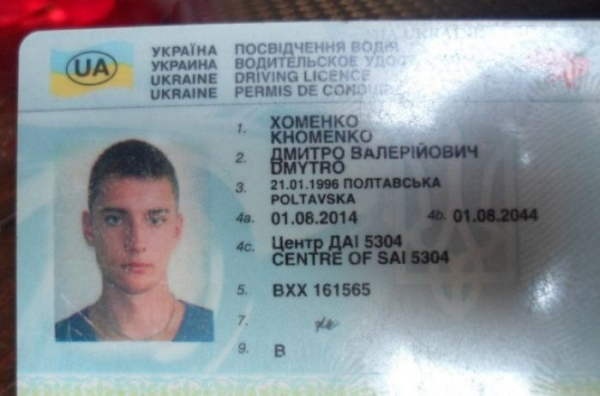

In [ ]:
image_name = "004.jpg"
result = age_recognition(image_name)
print(result, "years old")
image = cv2.imread(image_name)
cv2_imshow(image) #cv2.imshow